In [2]:
import rasterio
import rasterio.warp
import rasterio.windows
import rasterio.plot
from rasterio.coords import BoundingBox
import numpy as np
from glob import glob
import os
from osgeo import gdal

In [3]:
# 1 is forest, 2 is deforestation, 3 is degradation, 4 is non-forest
def map_labels(labels):
    shape = labels.shape
    flat = labels.flatten()
    flat[np.logical_or(flat == 1, flat == 100)] = 1
    flat[np.logical_and(flat >= 2, flat <= 99)] = 2
    flat[np.logical_and(flat >= 101, flat <= 253)] = 3
    flat[np.where(flat == 0)] = 4
    flat[np.where(flat > 253)] = 0
    return flat.reshape(shape)


def get_windowed_band(raw, deforestation):
    raw.meta.update(count = raw.count + 1)
    bounds = raw.bounds
    # Transform bounds of raw satellite images to deforestation crs
    bounds_tuple = rasterio.warp.transform_bounds(raw.crs, deforestation.crs, 
                                   bounds.left, bounds.bottom, 
                                   bounds.right, bounds.top, 
                                   densify_pts=21)
    warped_bounds = BoundingBox(bounds_tuple[0], bounds_tuple[1], bounds_tuple[2], bounds_tuple[3])
    # Create window applicable on deforestation
    window = rasterio.windows.from_bounds(warped_bounds.left, warped_bounds.bottom, 
                                      warped_bounds.right, warped_bounds.top,
                                      transform=deforestation.transform, precision=None,
                                      height=raw.height, width=raw.width)
    return deforestation.read(1, window=window)

def_files = glob("../data/deforestation/*.tif")

def get_deforestation_file(name):
    files = glob("../data/deforestation/*.tif")
    for f in files:
        if name.replace('-', '') in f:
            return f
    return None 

# Test cases for extracting data

In [12]:
satellite = rasterio.open("../data/raw/2017-01-22.tif")
deforestation = rasterio.open("../data/deforestation/S1-20150930-20170122_con.tif")
meta = satellite.meta
meta.update(count=satellite.count + 1)

def combined_tif(satellite, deforestation):
    with rasterio.open("../data/processed/test.tif", 'w+', **meta) as output:
        for i in range(1, 4):
            output.write_band(i, satellite.read(i))
        output.write_band(4, map_labels(get_windowed_band(satellite, deforestation)))
        
def combined_npy(satellite, deforestation):
    """This has problem with shape not being equal, need to write to TIFF first"""
    features = []
    for i in range(1, 4):
        features.append(satellite.read(i))
    labels = map_labels(get_windowed_band(satellite, deforestation))
    return np.array(features), np.array(labels)

In [78]:
test = rasterio.open("../data/processed/test.tif")
test.read(4)[4999]

array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)

## Display images

In [15]:
a = np.array([2,3,4,5,6])


(array([0]),)

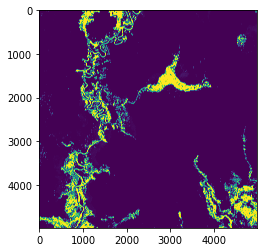

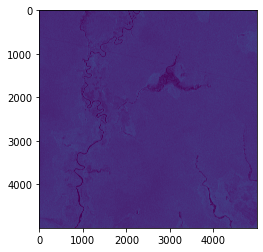

In [6]:
rasterio.plot.show(deforestation.read(1, window=window)) # Read only with given window
rasterio.plot.show(raw.read(2))